# Facebook Prophet을 활용한 주가 예측 모델

이번 튜토리얼 에서는 다음과 같은 **프로세스 파이프라인**으로 주가 예측을 진행합니다.

- FinanceDataReader를 활용하여 주가 데이터 받아오기
- Facebook Prophet을 활용하여 주가 예측

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 필요한 모듈 import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

## 데이터 (FinanceDataReader)

In [3]:
/pwd

'/content'

In [4]:
cd drive/MyDrive/bigdata_project/data

/content/drive/MyDrive/bigdata_project/data


In [5]:
ls

datareader_finbert_to_num_v2.xlsx
datareader_finbert_to_num.xlsx
datareader_finbert.xlsx
hyundai_stock_dataset_finBERT_notnull.xlsx
kakaobank_stock_dataset_finBERT_notnull.xlsx
naver_finance_news.xlsx
naver_news.xlsx
preprocessed_dup_eliminated_dataset_finBERT.xlsx
report.xlsx
samsung_stock_dataset_finBERT_notnull_select2.xlsx
samsung_stock_dataset_finBERT_notnull_select_column.xlsx
samsung_stock_dataset_finBERT_notnull.xlsx
stock_dataset_finBERT_notnull.xlsx


In [6]:
# 로우 데이터로 엑셀파일 로드
# 실행 전에 미리 구글 드라이브 마운트를 해야하고 동일 경로에서 엑셀파일을 읽어들여야 함
raw_data = pd.read_excel('samsung_stock_dataset_finBERT_notnull.xlsx') # 삼성
# raw_data = pd.read_excel('hyundai_stock_dataset_finBERT_notnull.xlsx') # 현대

raw_data = raw_data.set_index("Date")
raw_data = raw_data.drop(['PSAR-up','PSAR-down'],axis=1)
print(raw_data.shape)
raw_data = raw_data.dropna(axis=0) # 널값 있는 행 제거
raw_data

(1234, 36)


,Open,High,Low,Close,Volume,Change,Rn,MRn,Volatility10,Volatility30,...,PSAR,RSI,ADX,OBV,OSCILLATOR,negative,neutral,positive,sentiment,Next_day
Date,,,,,,,,,,,,,,,,,,,,,
2018-11-22,42000,42650,42000,42450,5970796,0.008314,1.008314,0.990828,0.038202,0.082674,...,45051.520000,40.881416,18.101735,-13453907,-417.647059,0.030520,0.000077,0.969403,1,42400
2018-11-23,42450,42600,41900,42400,5192638,-0.001178,0.998822,0.996927,0.037061,0.079820,...,44921.459200,40.567862,17.555025,-18646545,-731.029412,0.101236,0.007946,0.890818,1,42600
2018-11-26,42150,42800,42100,42600,6613009,0.004717,1.004717,1.003951,0.028850,0.079954,...,44796.600832,42.468657,16.765372,-12033536,-944.852941,0.171952,0.015814,0.812233,1,43050
2018-11-27,42900,43100,42500,43050,8367091,0.010563,1.010563,1.004701,0.030665,0.080638,...,44676.736799,46.606462,15.616858,-3666445,-830.147059,0.046501,0.000300,0.953199,1,43150
2018-11-28,42800,43200,42750,43150,6943099,0.002323,1.002323,1.005868,0.030439,0.079615,...,44561.667327,47.509934,14.590579,3276654,-618.676471,0.762649,0.123316,0.114036,-1,43150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-02,66600,67000,66400,66700,14959443,-0.010386,0.989614,1.001076,0.033406,0.070579,...,68543.814928,47.724304,10.877366,640155380,-22.352941,0.000585,0.499241,0.500174,1,66800
2022-06-03,67200,67300,66800,66800,8222883,0.001499,1.001499,0.995561,0.032744,0.070580,...,68482.938629,48.344501,10.158162,648378263,148.529412,0.001084,0.998356,0.000561,0,65500
2022-06-07,66200,66400,65400,65500,19355755,-0.019461,0.980539,0.990551,0.035700,0.072899,...,68423.279857,41.458445,10.635226,629022508,47.941176,0.000039,0.000086,0.999876,1,65300


**FinanceDataReader**는 주가 데이터를 편리하게 가져올 수 있는 파이썬 패키지입니다.

- [GitHub Repo](https://github.com/FinanceData/FinanceDataReader)

**FinanceDataReader**가 아직 설치 되지 않으신 분들은 아래의 주석을 해제한 후 명령어로 설치해 주시기 바랍니다.

In [17]:
!pip install finance-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48 kB 3.6 MB/s 


In [18]:
import FinanceDataReader as fdr

In [36]:
stock = raw_data

## 시각화

Text(0, 0.5, 'price')

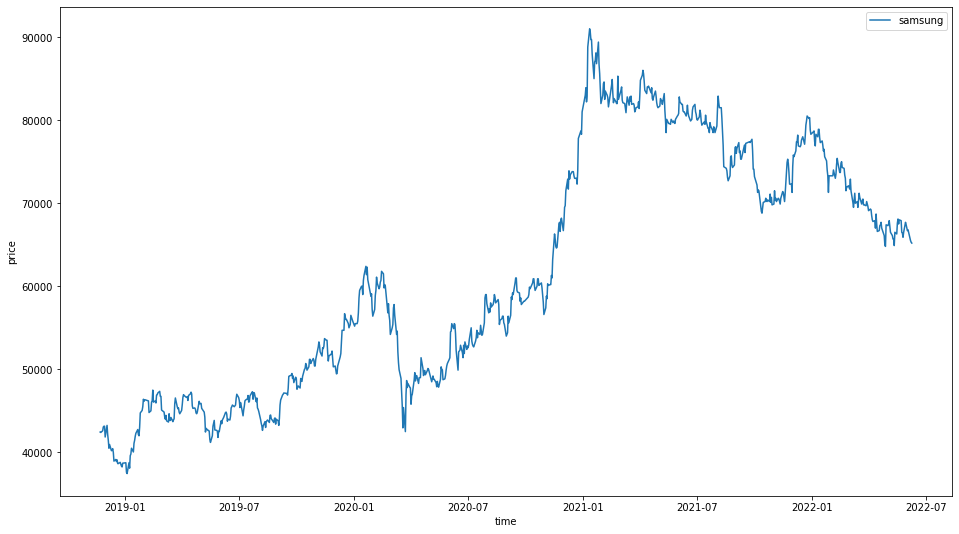

In [37]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=stock['Close'], x=stock.index, data=stock, label='samsung')
plt.xlabel('time')
plt.ylabel('price')

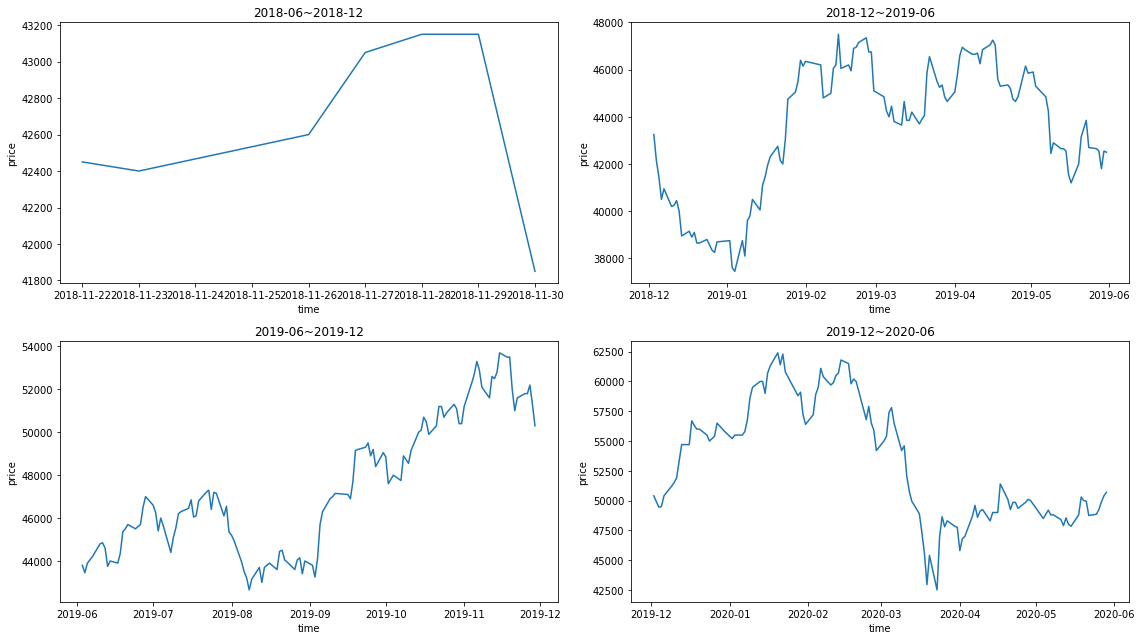

In [16]:
time_steps = [['2018-06', '2018-12'], 
              ['2018-12', '2019-06'], 
              ['2019-06', '2019-12'], 
              ['2019-12', '2020-06']]

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 9)
for i in range(4):
    ax = axes[i//2, i%2]
    df = stock.loc[(stock.index > time_steps[i][0]) & (stock.index < time_steps[i][1])]
    sns.lineplot(y=df['Close'], x=df.index, ax=ax)
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
plt.tight_layout()
plt.show()

## Prophet

### 모듈 import

In [20]:
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly

### 컬럼

- 반드시 **y** 컬럼과 **ds** 컬럼이 존재해야합니다.
- 예측 값은 **y**, 시계열 데이터는 **ds**에 지정합니다.

In [21]:
stock['y'] = stock['Close']
stock['ds'] = stock.index

In [22]:
stock.head()

,Open,High,Low,Close,Volume,Change,Rn,MRn,Volatility10,Volatility30,...,ADX,OBV,OSCILLATOR,negative,neutral,positive,sentiment,Next_day,y,ds
Date,,,,,,,,,,,,,,,,,,,,,
2018-11-22,42000,42650,42000,42450,5970796,0.008314,1.008314,0.990828,0.038202,0.082674,...,18.101735,-13453907,-417.647059,0.030520,0.000077,0.969403,1,42400,42450,2018-11-22
2018-11-23,42450,42600,41900,42400,5192638,-0.001178,0.998822,0.996927,0.037061,0.079820,...,17.555025,-18646545,-731.029412,0.101236,0.007946,0.890818,1,42600,42400,2018-11-23
2018-11-26,42150,42800,42100,42600,6613009,0.004717,1.004717,1.003951,0.028850,0.079954,...,16.765372,-12033536,-944.852941,0.171952,0.015814,0.812233,1,43050,42600,2018-11-26
2018-11-27,42900,43100,42500,43050,8367091,0.010563,1.010563,1.004701,0.030665,0.080638,...,15.616858,-3666445,-830.147059,0.046501,0.000300,0.953199,1,43150,43050,2018-11-27
2018-11-28,42800,43200,42750,43150,6943099,0.002323,1.002323,1.005868,0.030439,0.079615,...,14.590579,3276654,-618.676471,0.762649,0.123316,0.114036,-1,43150,43150,2018-11-28


### prophet 객체 선언 및 학습

In [23]:
m = Prophet()
m.fit(stock)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


**period**에 예측 하고 싶은 기간을 입력 합니다.

예측할 시계열 row가 추가 됩니다.

In [24]:
future = m.make_future_dataframe(periods=30)
future.tail()

,ds
899,2022-07-05
900,2022-07-06
901,2022-07-07
902,2022-07-08
903,2022-07-09


- `predict`로 예측을 진행합니다.
- `predict` 안에는 이전 단계에서 만들어준 future 데이터프레임을 입력합니다.


In [25]:
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
899,2022-07-05,64325.906897,59586.233845,65049.100595,64167.120863,64476.519934,-1973.450384,-1973.450384,-1973.450384,-582.841252,-582.841252,-582.841252,-1390.609132,-1390.609132,-1390.609132,0.0,0.0,0.0,62352.456513
900,2022-07-06,64277.038370,59336.670669,64780.452744,64096.235184,64440.336968,-2102.577363,-2102.577363,-2102.577363,-679.998723,-679.998723,-679.998723,-1422.578640,-1422.578640,-1422.578640,0.0,0.0,0.0,62174.461007
901,2022-07-07,64228.169843,59350.168689,64654.919709,64028.067720,64411.770699,-2191.599308,-2191.599308,-2191.599308,-744.018359,-744.018359,-744.018359,-1447.580948,-1447.580948,-1447.580948,0.0,0.0,0.0,62036.570535
902,2022-07-08,64179.301315,59241.092392,65007.450396,63958.426966,64380.195357,-2261.727804,-2261.727804,-2261.727804,-796.605244,-796.605244,-796.605244,-1465.122560,-1465.122560,-1465.122560,0.0,0.0,0.0,61917.573511
903,2022-07-09,64130.432788,61739.803224,67262.965689,63891.511823,64339.968644,313.871535,313.871535,313.871535,1788.683104,1788.683104,1788.683104,-1474.811569,-1474.811569,-1474.811569,0.0,0.0,0.0,64444.304323


In [26]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].iloc[-40:-20]

,ds,yhat,yhat_lower,yhat_upper
864,2022-05-25,64785.177526,62152.479463,67100.376914
865,2022-05-26,64728.882898,62145.074305,67395.293369
866,2022-05-27,64684.840263,61999.291706,67325.958457
867,2022-05-30,64729.416165,62060.604858,67401.786045
868,2022-05-31,64923.863881,62180.602041,67567.925592
869,2022-06-02,64759.457259,61886.958497,67505.380867
870,2022-06-03,64699.110581,62144.113216,67384.786965
871,2022-06-07,64830.908661,62177.812281,67429.486779
872,2022-06-08,64699.111267,62083.189944,67291.805904
873,2022-06-09,64594.463547,61880.311430,67302.695656


### 시각화

`plot`은 트렌드와 함께 예측된 결과물을 시각화하여 보여줍니다.

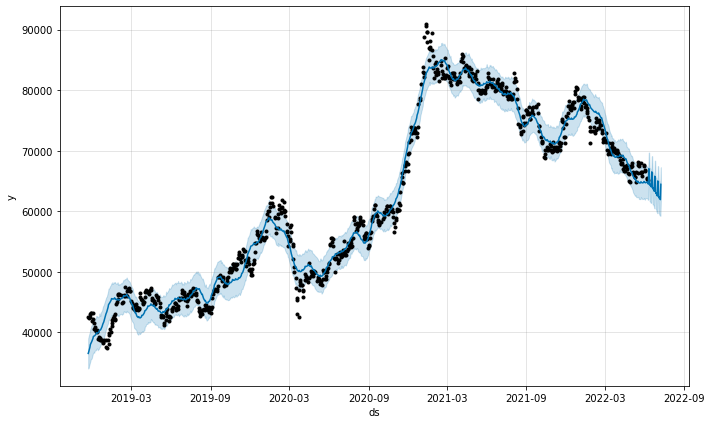

In [27]:
fig = m.plot(forecast)

### plotly 활용

In [28]:
fig = plot_plotly(m, forecast)
fig

### 컴포넌트 별 시각화

컴포넌트 별 시각화에서는 seasonality 별 시각화를 진행해 볼 수 있습니다.

**trend, yearly, weekly 데이터를 시각화**하여 보여 줍니다.

In [29]:
plot_components_plotly(m, forecast)

### change points

By default, Prophet specifies 25 potential changepoints which are uniformly placed in the first 80% of the time series. The vertical lines in this figure indicate where the potential changepoints were placed:

처음 80%의 시계열 데이터에 대하여 잠재적인 25개의 changepoints를 만들고, 그 중 선별하여 최종 changepoints를 그래프에서 vertical line으로 그려주게 됩니다.

In [30]:
from fbprophet.plot import add_changepoints_to_plot

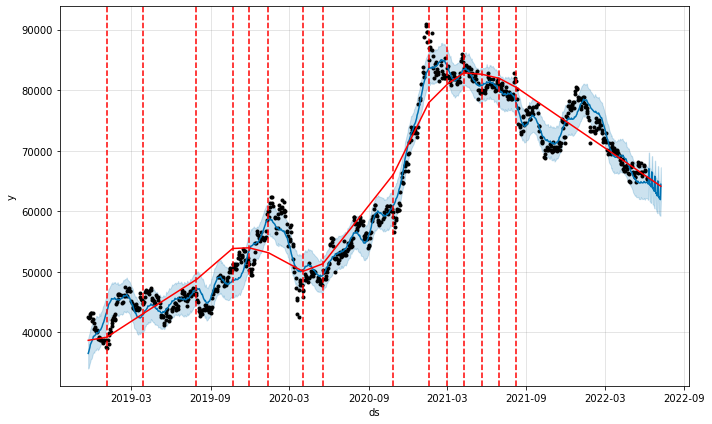

In [31]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

### flexibility 조절

If the trend changes are being overfit (too much flexibility) or underfit (not enough flexibility), you can adjust the strength of the sparse prior using the input argument changepoint_prior_scale. By default, this parameter is set to 0.05. Increasing it will make the trend more flexible:

flexibility **계수가 낮으면 과소적합, 높으면 과대적합**하여 예측하게 됩니다.

중요한 hyperparameter 입니다.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


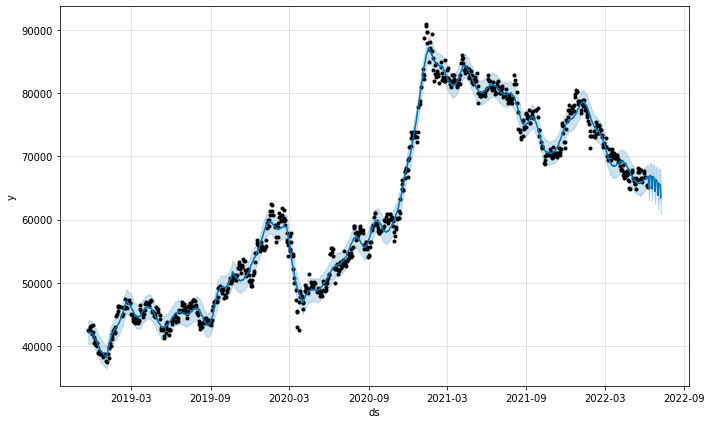

In [32]:
m = Prophet(changepoint_prior_scale=0.8)
forecast = m.fit(stock).predict(future)
fig = m.plot(forecast)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


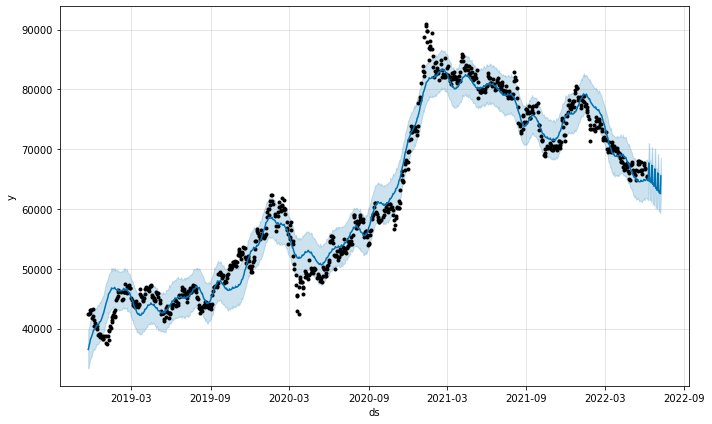

In [33]:
m = Prophet(changepoint_prior_scale=0.01)
forecast = m.fit(stock).predict(future)
fig = m.plot(forecast)